# import packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import scanpy as sc
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from anndata import AnnData, read_h5ad

import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

sc.set_figure_params(dpi=100,dpi_save=300)


/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_30468/3103008571.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# load data

In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/preculture_manuscript/processed_files/reanalyse/'
adata_file = pathToData + '20230124_adata_dataset_ESC_all.h5ad'  # the file that will store the analysis results
adata = sc.read(adata_file)

In [3]:
adata.obs['Condition'] = adata.obs['condition']
adata.uns['Condition_colors'] = adata.uns['condition_colors']
adata.obs['Condition'] = [sub.replace('con', '') for sub in adata.obs['Condition']]
adata.obs['Condition'] = adata.obs['Condition'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].cat.reorder_categories(['1','2','3','4','5','6'])


# umap plots

In [4]:
adata.obs.head(2)

n_counts  n_genes  percent_mito   S_score  G2M_score phase  \
e1_1.m-ESC_con1     7306.0     3604      0.068478  0.024311   0.121200   G2M   
e1_10.m-ESC_con1    9948.0     4020      0.032744  0.075215   0.022867     S   

                  batch        name condition plate leiden Condition  
e1_1.m-ESC_con1   m-ESC  m-ESC_con1      con1    e1      1         1  
e1_10.m-ESC_con1  m-ESC  m-ESC_con1      con1    e1      4         1

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


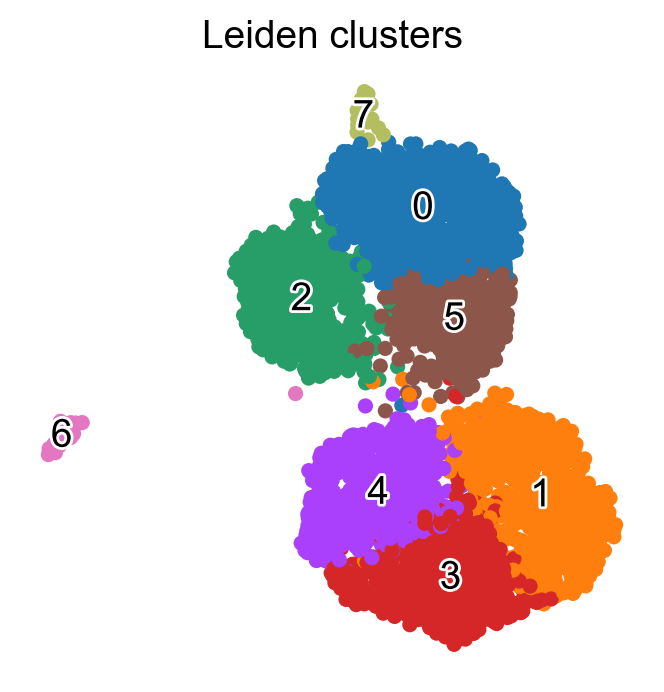

In [5]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'], use_raw=True, size = 120, frameon=False,
          title = 'Leiden clusters', legend_loc = 'on data',
           legend_fontoutline = 2, legend_fontweight='normal')

In [6]:
adata.obs['celltype'] = adata.obs['leiden']
adata.obs['celltype'] = [sub.replace('5', '0') for sub in adata.obs['celltype']]
adata.obs['celltype'] = adata.obs['celltype'].astype('category')
adata.obs['celltype'] = adata.obs['celltype'].cat.reorder_categories(['0','2','4','1','3','7','6'])
adata.rename_categories('celltype',['Primed Pluripotency','Primed Ectoderm','Epiblast-like',
                                    'Ground State Pluripotency','Naive Pluripotency',
                                    'Mesoderm Progenitors','Endoderm Progenitors'])

adata.obs['celltype2'] = adata.obs['celltype']
adata.rename_categories('celltype2',['Primed \n Pluripotency','Primed Ectoderm','Epiblast-like',
                                    'Ground State \n Pluripotency','Naive \n Pluripotency',
                                    'Mesoderm Progenitors','Endoderm Progenitors'])

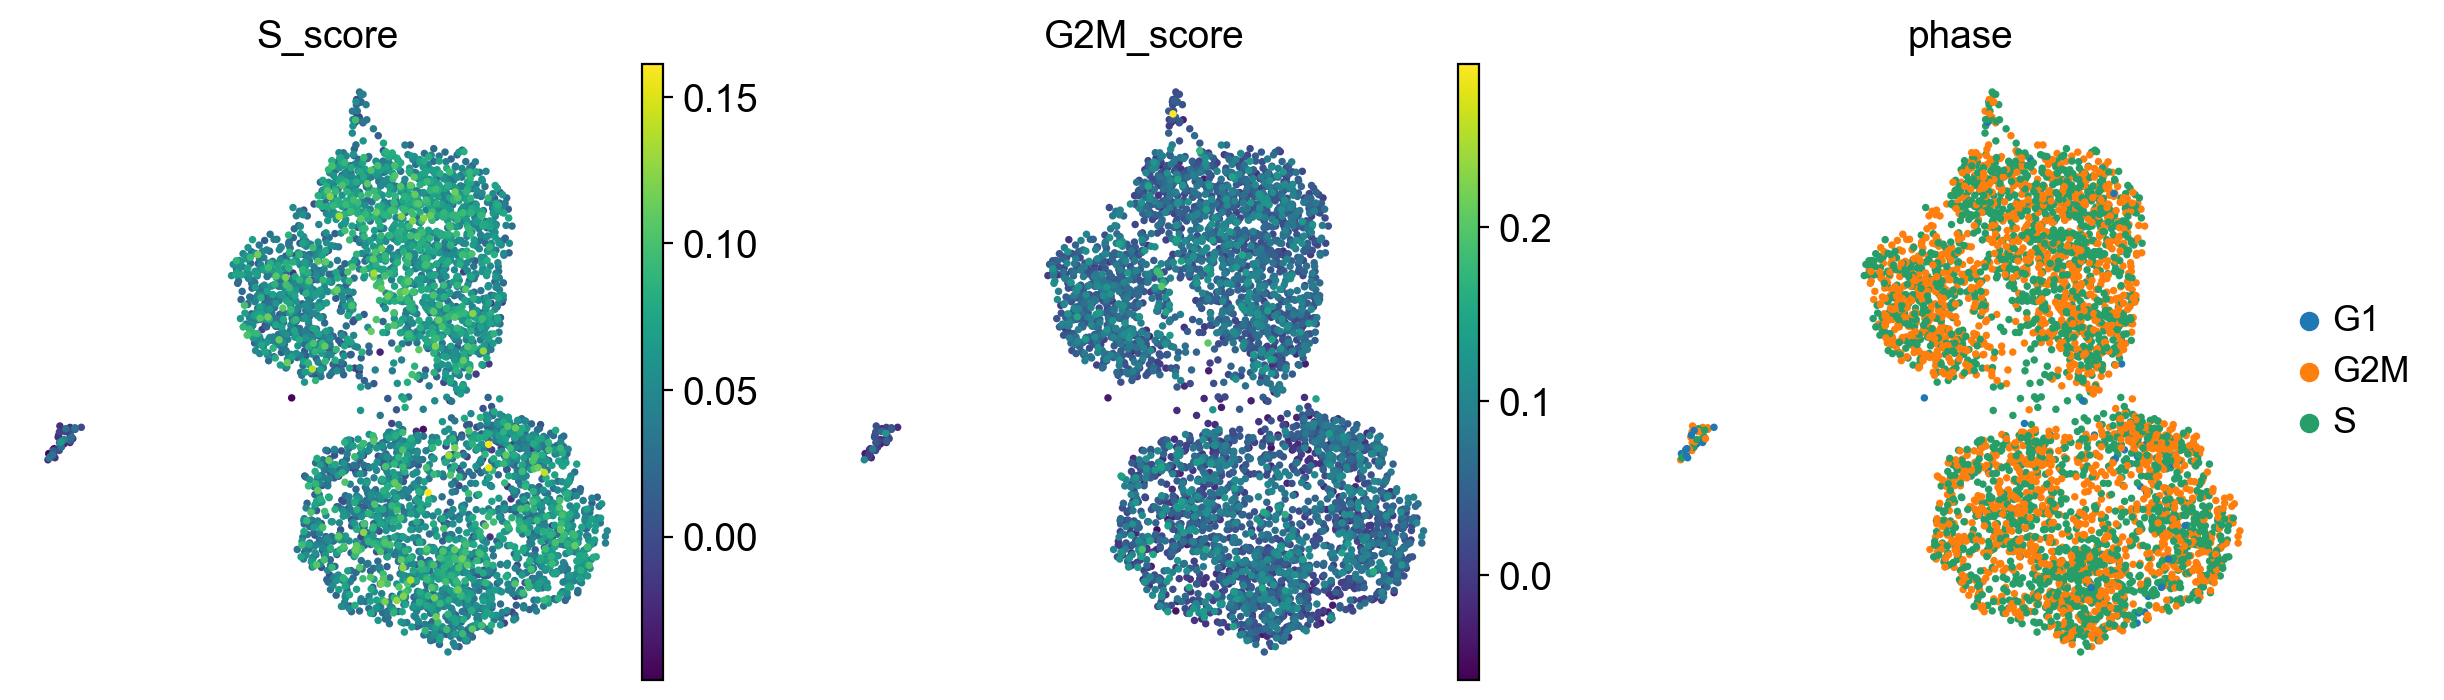

In [7]:
sc.pl.umap(adata,color = ['S_score','G2M_score','phase'], frameon = False)

computing density on 'umap'
--> added
    'umap_density_phase', densities (adata.obs)
    'umap_density_phase_params', parameter (adata.uns)


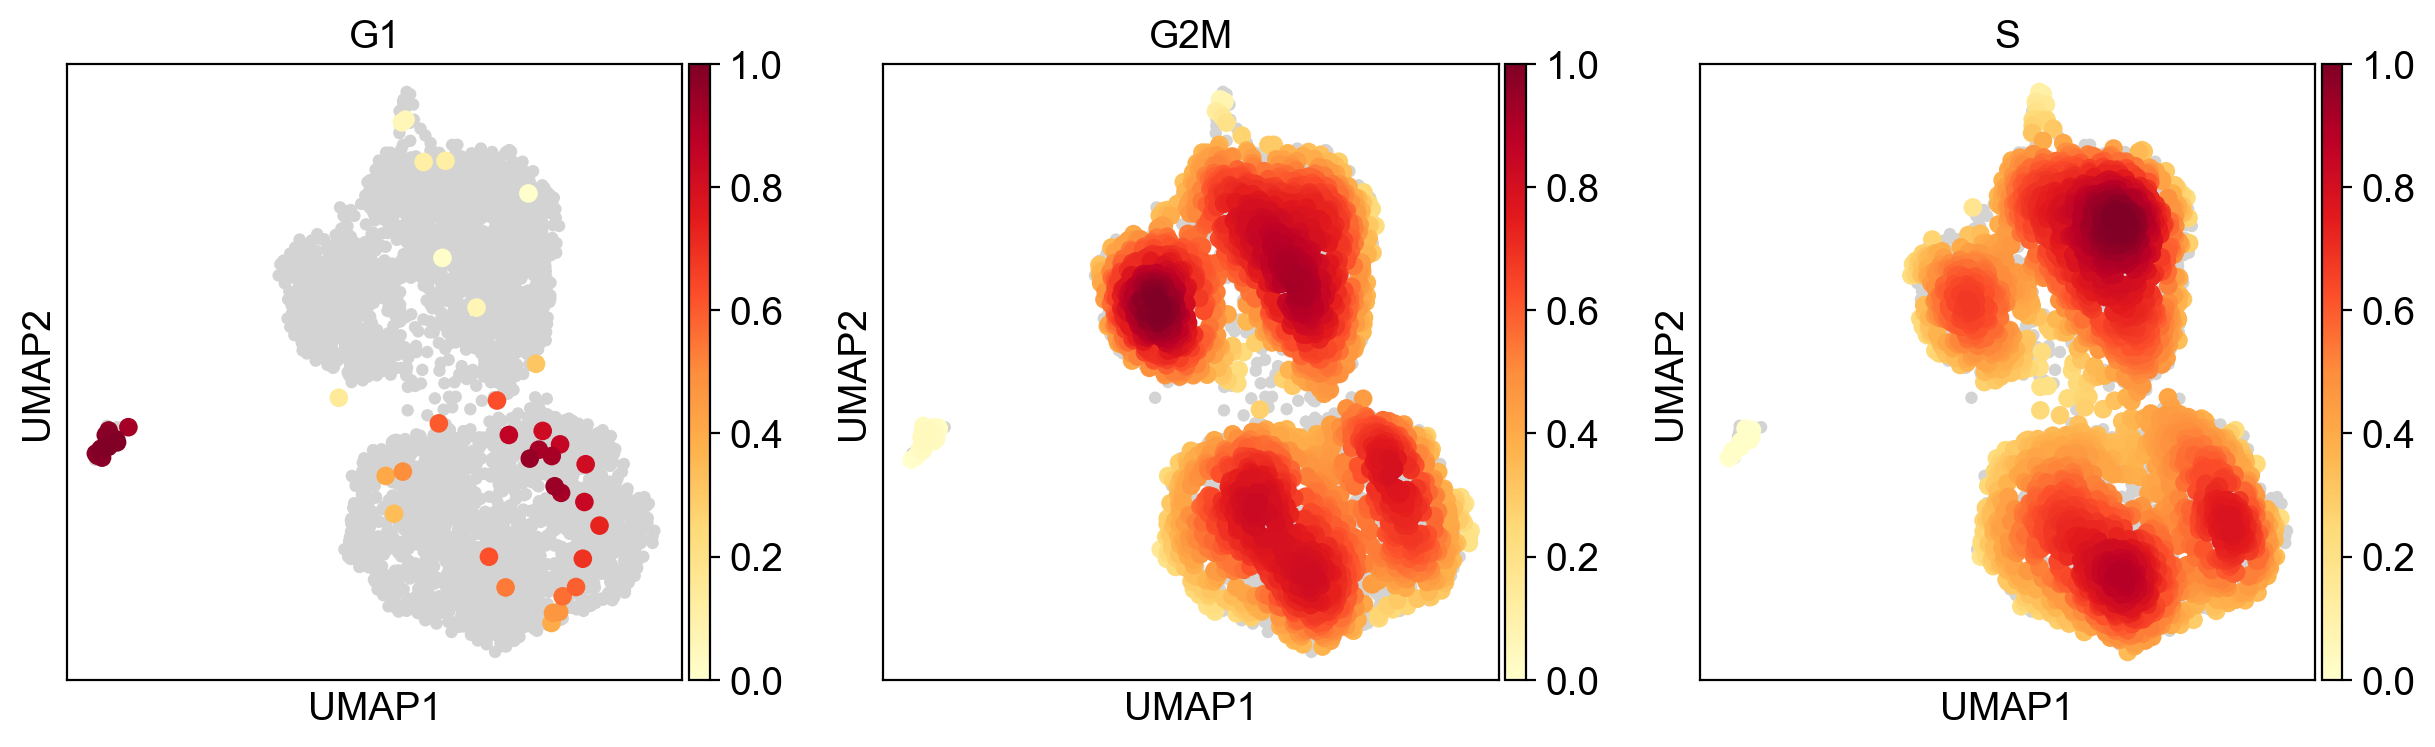

In [8]:
sc.tl.embedding_density(adata,groupby='phase')
sc.pl.embedding_density(adata,groupby='phase')

#### make figure panels 2A, 2B, S2A

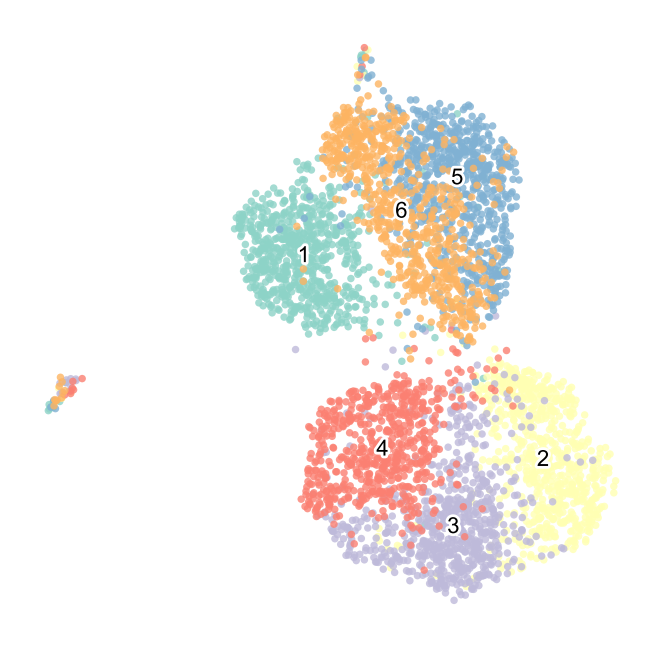

In [9]:
sc.pl.umap(adata,color='Condition',frameon=False, alpha=0.8,title='', legend_loc = 'on data', legend_fontsize=8,
           legend_fontoutline = 2, legend_fontweight='normal')

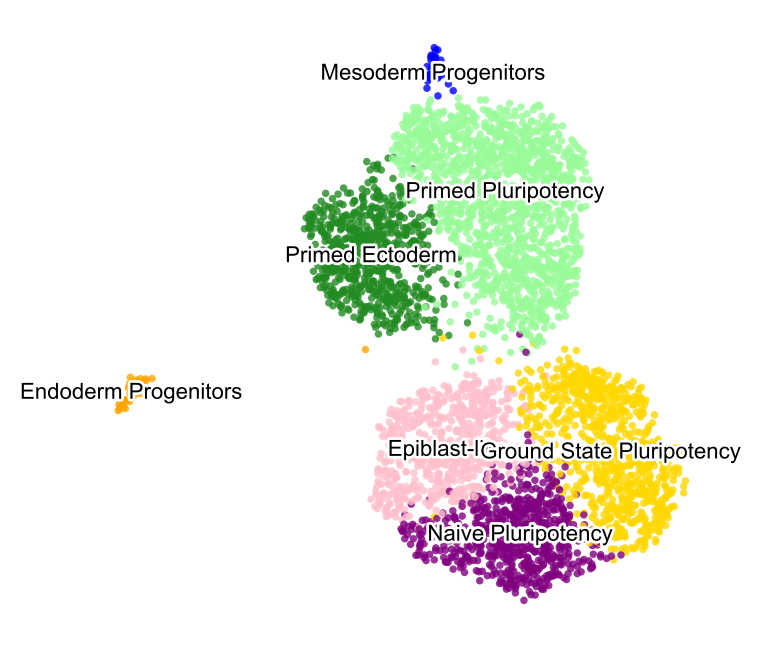

In [10]:

sc.pl.umap(adata,color='celltype',frameon=False, alpha=0.8,title='', legend_loc = 'on data', legend_fontsize=8,
           palette = ['palegreen','forestgreen','pink','gold','purple','blue','orange'],
           legend_fontoutline = 2, legend_fontweight='normal')

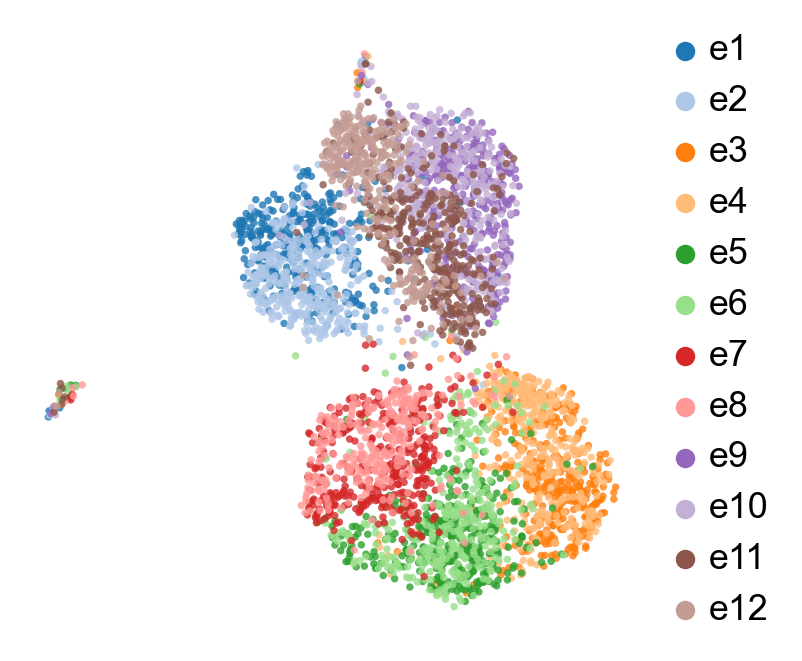

In [11]:
sc.pl.umap(adata,color='plate',frameon=False, alpha=0.8,title='', palette = sns.color_palette('tab20',12), #legend_loc = 'on data', legend_fontsize=10,
           legend_fontoutline = 2, legend_fontweight='normal')

# violin plots

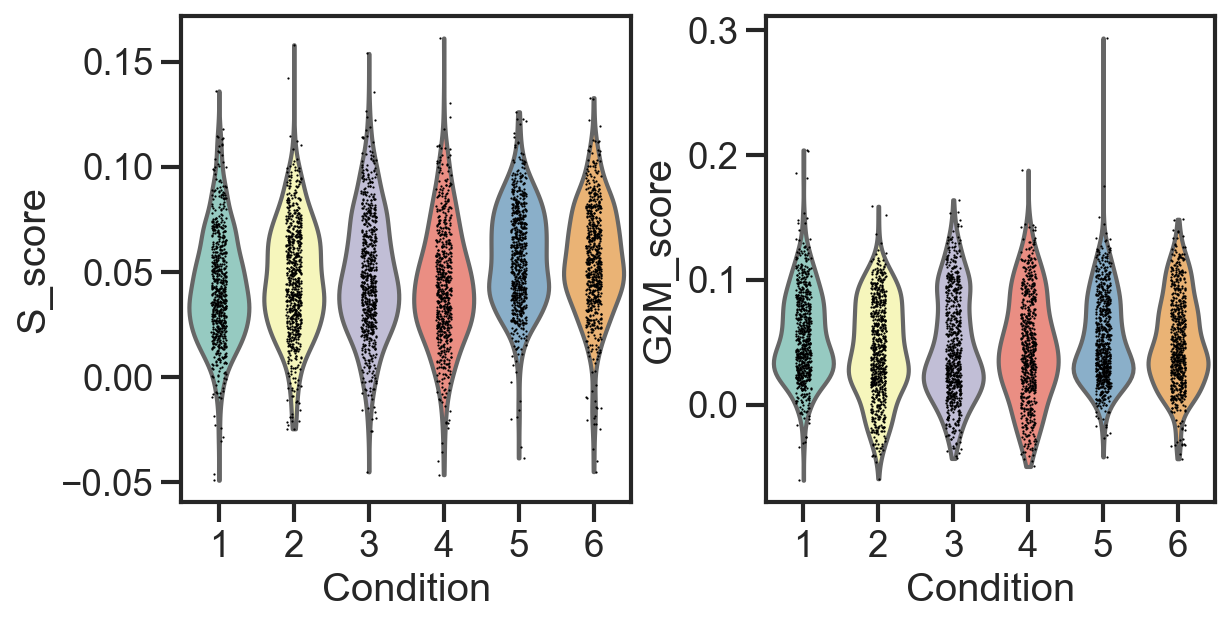

In [26]:
sns.set_style('white')
sns.set_context('talk')
sns.set_style('ticks')
sc.pl.violin(adata, ['S_score','G2M_score'], multi_panel=True, groupby = 'Condition')

#### make figure panels S2B-E

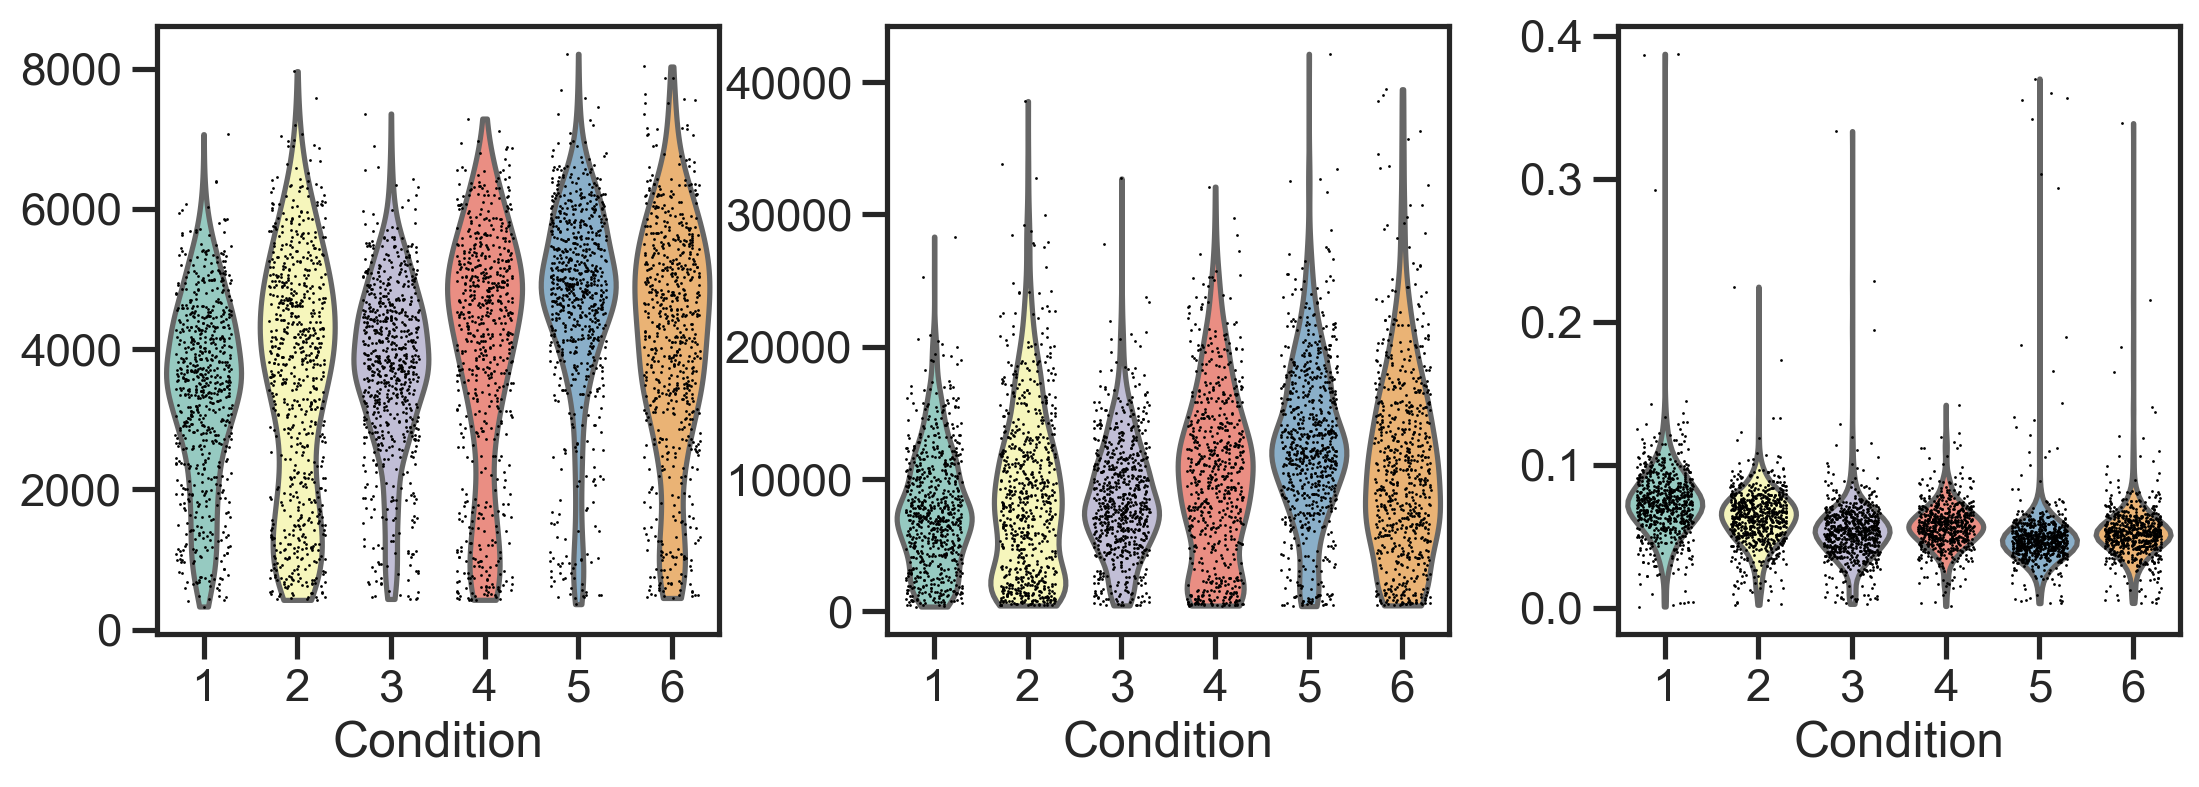

<Figure size 400x400 with 0 Axes>

In [13]:
sc.pl.violin(adata, ['n_genes','n_counts','percent_mito'], multi_panel=True, groupby = 'Condition',rotation = 0, jitter = 0.3, 
             size = 1, ylabel='', xlabel='Condition')
sns.despine()

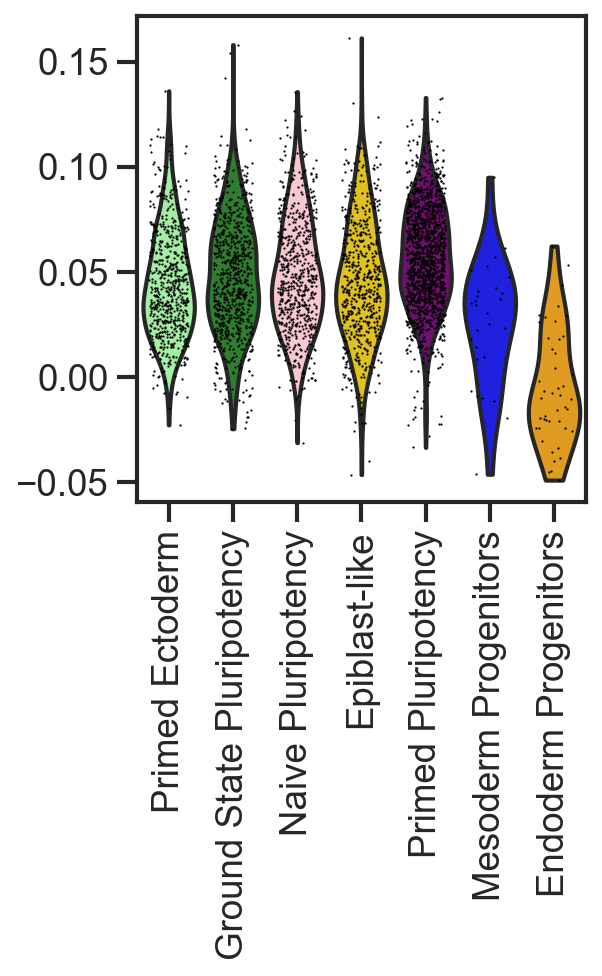

In [27]:
sc.pl.violin(adata, ['S_score'], multi_panel=True, groupby = 'celltype',rotation = 90, jitter = 0.3, size = 1, ylabel='', xlabel='',
            save = 'violin_cellcycle_celltypes.png')


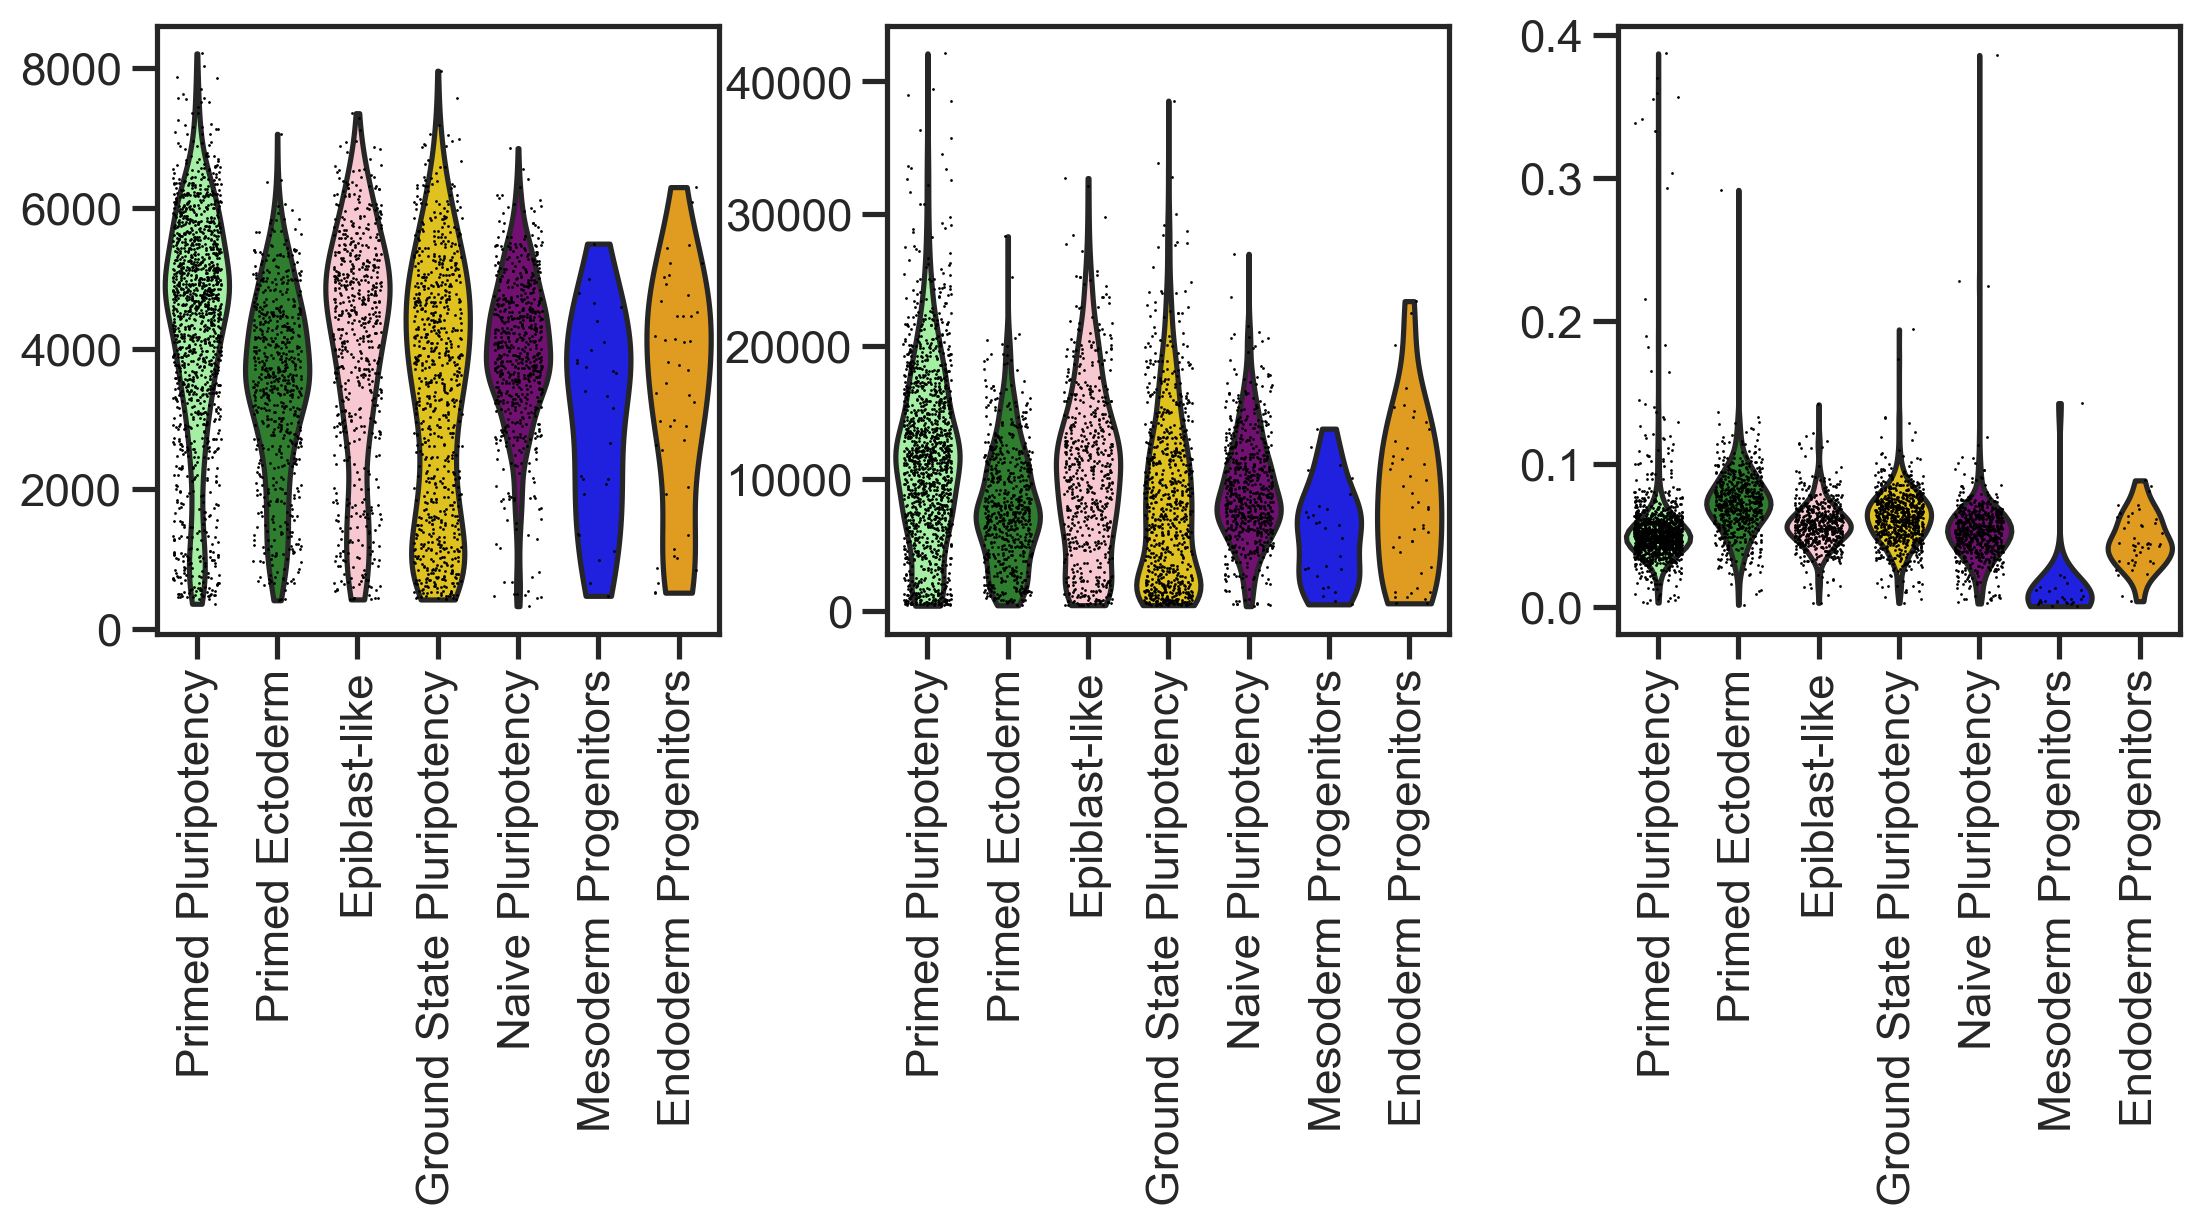

<Figure size 400x400 with 0 Axes>

In [15]:
sc.pl.violin(adata, ['n_genes','n_counts','percent_mito'], multi_panel=True, 
             groupby = 'celltype',rotation = 90, jitter = 0.3, size = 1, ylabel='', xlabel='')
sns.despine()

# heatmap and dotplot of marker genes

#### make figure panels 2H, S2F, S2A insert

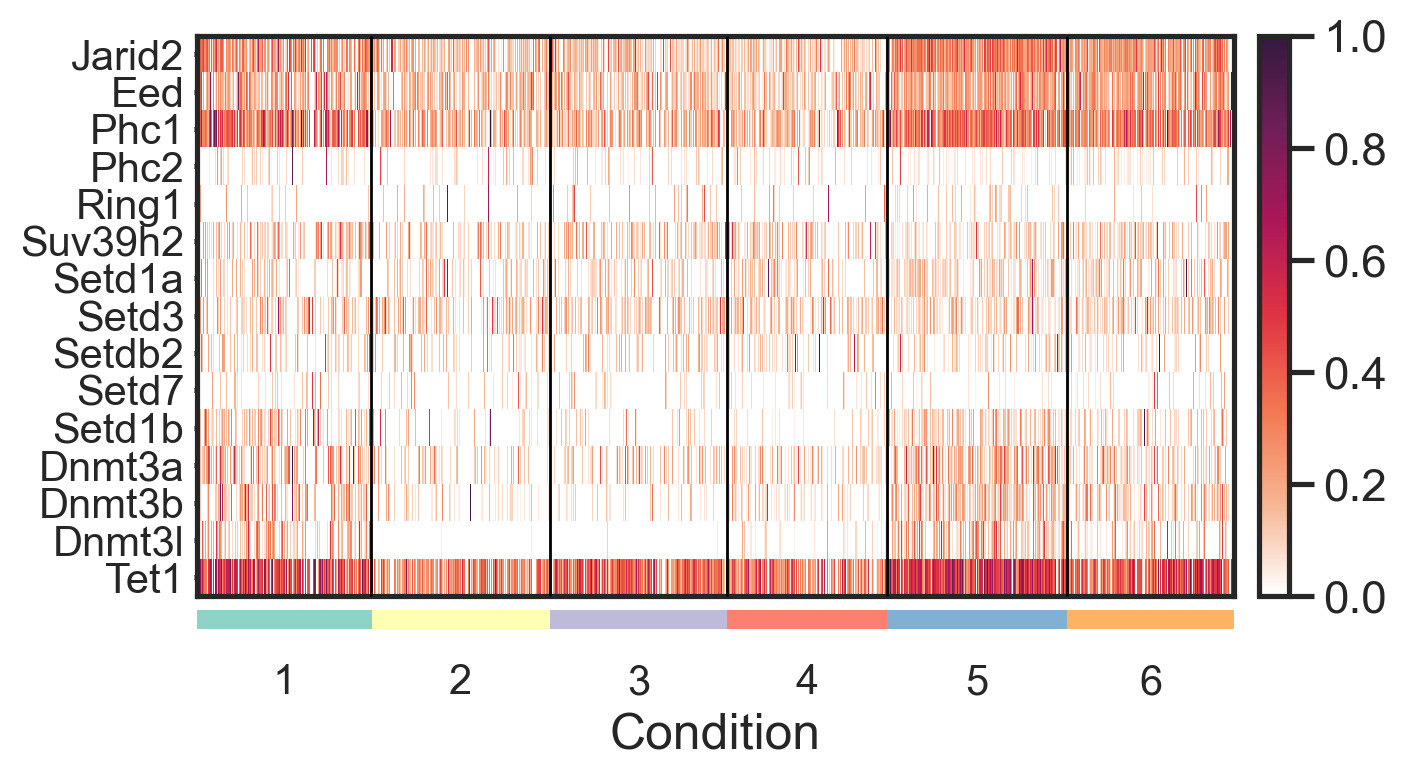

In [16]:
test_palette = sns.blend_palette(["white",'#f6b48f', '#f37651', '#e13342', '#ad1759', '#701f57', '#35193e'], as_cmap=True)

genes2 = ['Jarid2', "Eed", "Phc1","Phc2","Ring1", "Suv39h2",
          'Setd1a', 'Setd3', 'Setdb2', 'Setd7', 'Setd1b',
          'Dnmt3a','Dnmt3b','Dnmt3l', 'Tet1']
polycomb = ['Eed','Jarid2','Phc1','Suv39h2','Ezh2','Phc2','Suz12','Prc1','Ring1'] #Prc2
k4 = ['Setd1b','Setd1a','Setdb2','Setd5','Setd7','Setd3']
dname = ['Dnmt1','Dnmt3a','Dnmt3b','Dnmt3l', 'Tet1']

genes = polycomb + k4 + dname

ax = sc.pl.heatmap(adata, genes2, groupby='Condition', cmap=test_palette, 
                   swap_axes = True, figsize = (7,4), 
                   standard_scale='var',log=True)# , categories_order = order)




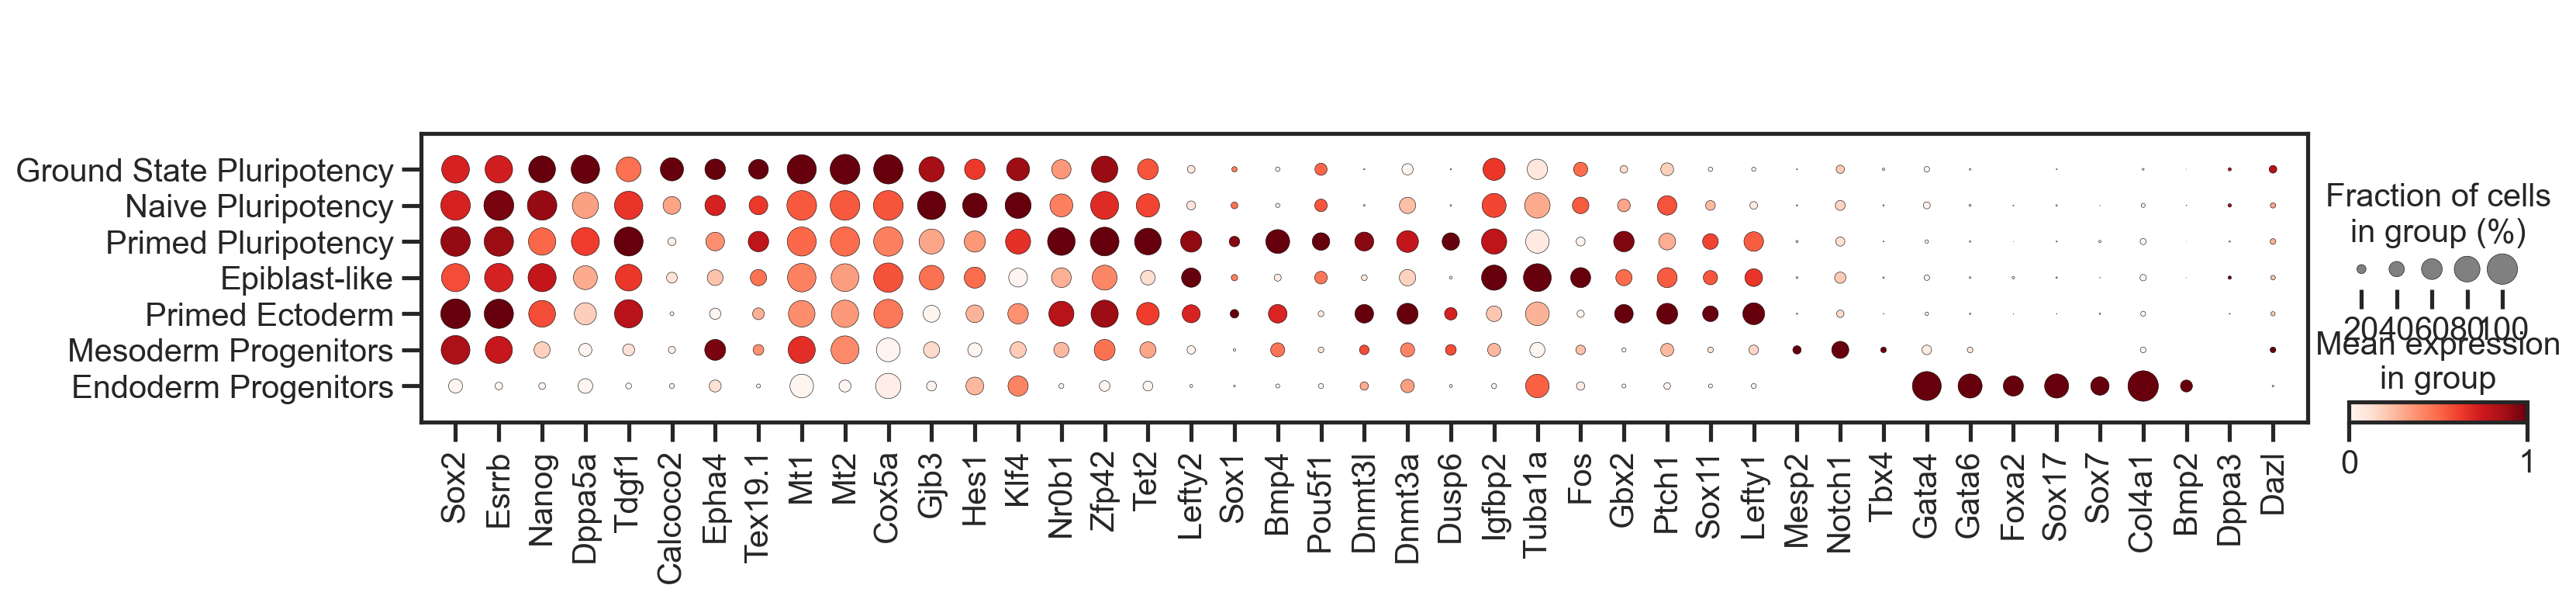

In [17]:
order = ['Ground State Pluripotency','Naive Pluripotency', 'Primed Pluripotency',
        'Epiblast-like','Primed Ectoderm','Mesoderm Progenitors','Endoderm Progenitors']
adata.obs['celltype'] = adata.obs['celltype'].cat.reorder_categories(order)

marker_genes = [#core pluripotency
    #'Cdh1',
    'Sox2','Esrrb','Nanog','Dppa5a','Tdgf1', #
    # 1 ground state pluripotency
    'Calcoco2','Epha4','Tex19.1','Mt1','Mt2','Cox5a',
    # 3 naive 
    'Gjb3','Hes1', 'Klf4','Nr0b1','Zfp42',
    # 0 (neural) primed pluripotency
    'Tet2','Lefty2',#'Dppa4','Dppa2',
    'Sox1','Bmp4', 'Pou5f1',
    'Dnmt3l','Dnmt3a','Dusp6',
    # 4 Epi-like
    'Igfbp2','Tuba1a','Fos',#'Elf3','Msmo1', #Cdkn1a
    # 2 -shh signalling
    'Gbx2','Ptch1', 'Sox11','Lefty1',#'Trh', 'Cdkn1c', 'Runx1t1','Ptch1','Ina',
    # 7 - cell cycle arrest/ mesoderm prog
    'Mesp2','Notch1','Tbx4',#'Ccng1', 'Trp53inp1', 'Mdm2', 'Mdm4',
    # 6 - Endoderm
    'Gata4','Gata6','Foxa2','Sox17','Sox7','Col4a1','Bmp2',#'Ccnd2','Lmo4','Car2',# 'Lamb1','Col4a2','Serpinh1','Lama1','Srgn',
    #PGC
    'Dppa3','Dazl'
               ]
sns.set_context('talk')
ax = sc.pl.dotplot(adata, marker_genes, groupby='celltype',
                   save = 'dotplot_mESC_revised.png',
                   standard_scale='var')

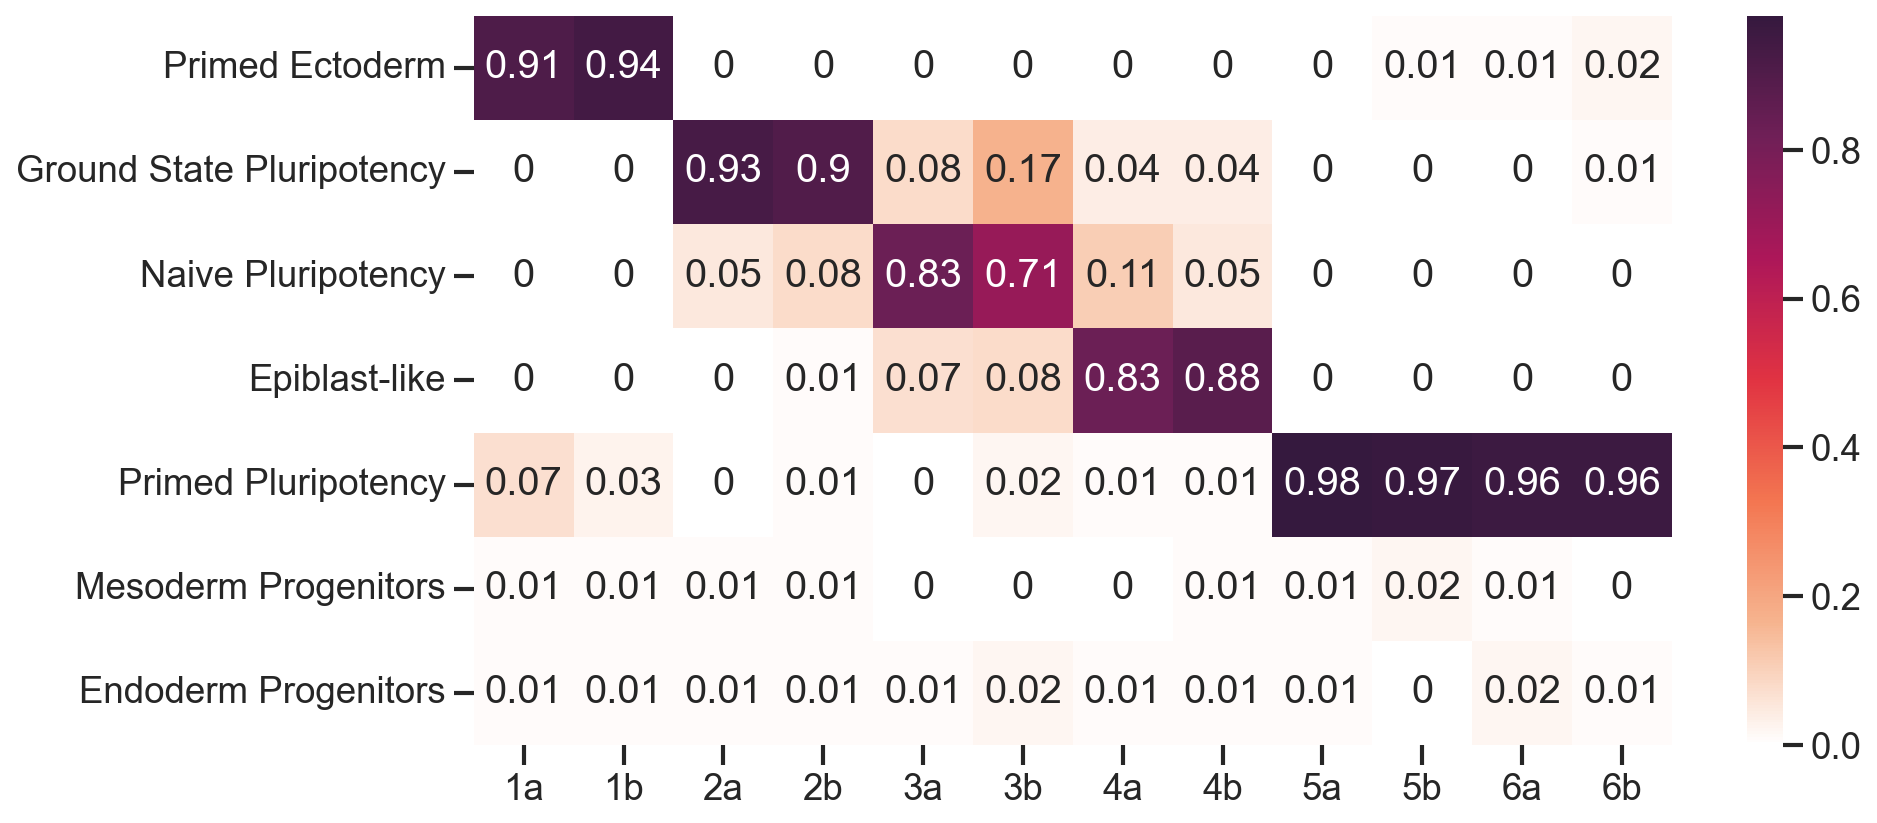

In [28]:
test_palette = sns.blend_palette(["white",'#f6b48f', '#f37651', '#e13342', '#ad1759', '#701f57', '#35193e'], as_cmap=True)

order = ['Primed Ectoderm','Ground State Pluripotency','Naive Pluripotency', 'Epiblast-like','Primed Pluripotency',
        'Mesoderm Progenitors','Endoderm Progenitors']

adata.obs['celltype'] = adata.obs['celltype'].cat.reorder_categories(order)

cols = {'All':'Total','e1':'1a','e2':'1b','e3':'2a','e4':'2b','e5':'3a',
        'e6':'3b','e7':'4a','e8':'4b','e9':'5a','e10':'5b','e11':'6a','e12':'6b'}
fig,ax = plt.subplots(figsize = (12,6))

sns.heatmap(pd.crosstab(adata.obs['celltype'],adata.obs['plate'], 
                        margins=True,normalize='columns').round(decimals=2).rename(index={'All':'Total'}, 
                                                                                   columns=cols).loc[order].iloc[:,:-1],
            cmap = test_palette,annot = True,ax=ax, fmt='g')# vmin = 0, vmax = 200)
ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('mESC_platedistribution_ratios.png',dpi=300, bbox_inches='tight')


# correlation plots

#### make figure panels S2G-H

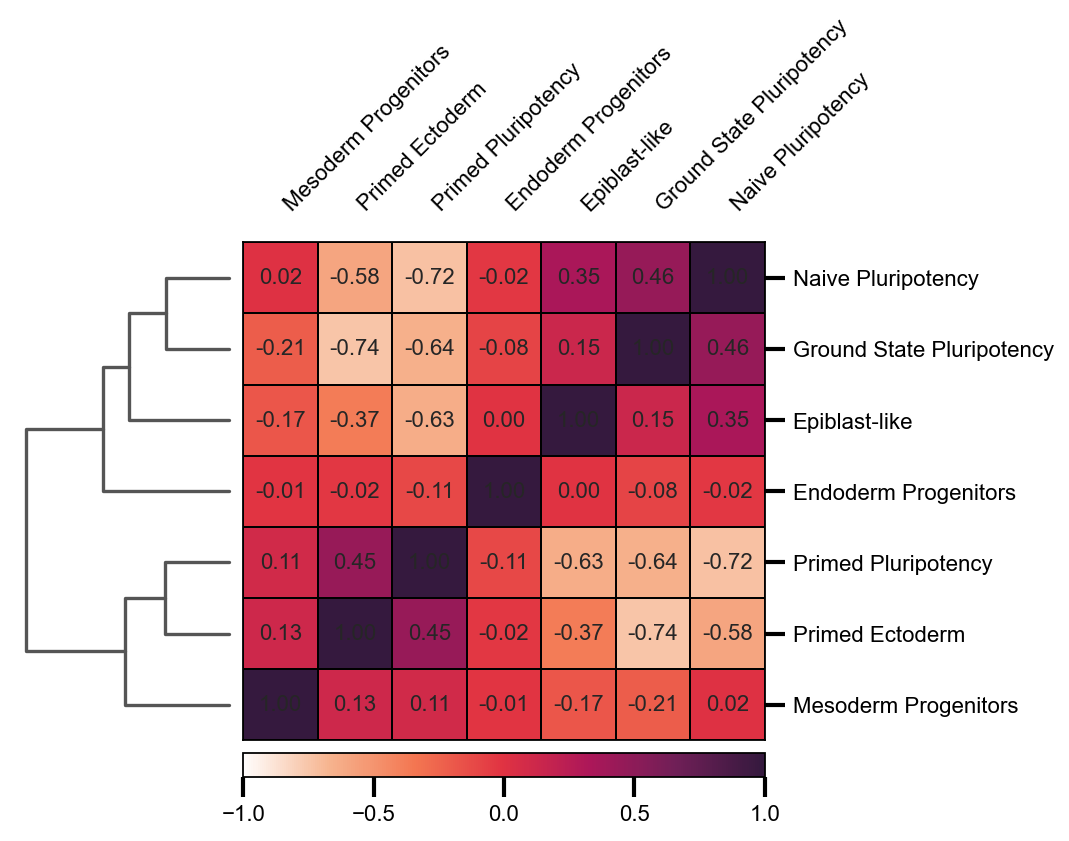

In [23]:
sc.set_figure_params(scanpy=True, fontsize=10, dpi = 80, dpi_save=300)
ax = sc.pl.correlation_matrix(adata, 'celltype', cmap=test_palette,show_correlation_numbers=True, save='corr_celltypes.png')

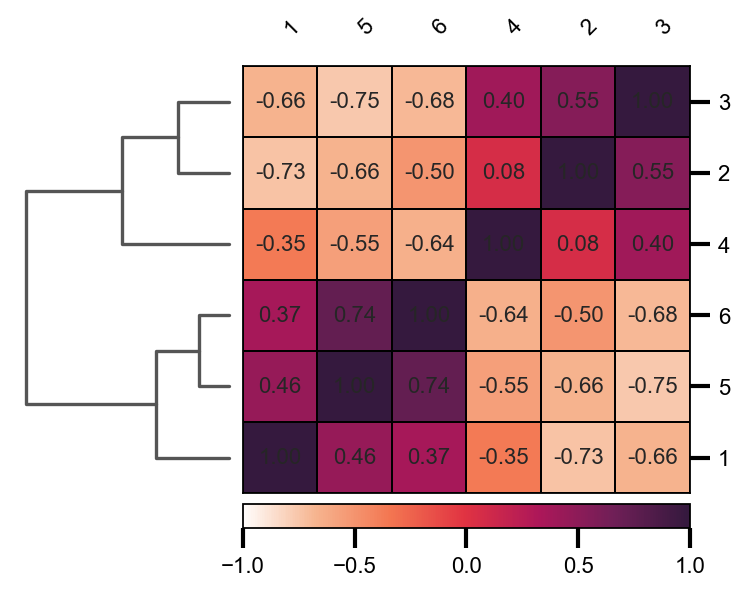

In [24]:
ax = sc.pl.correlation_matrix(adata, 'Condition', cmap=test_palette,show_correlation_numbers=True,save='corr_conditions.png')

# value counts

In [53]:
adata.obs['condition'].value_counts()

con5    722
con2    714
con3    709
con1    698
con6    666
con4    638
Name: condition, dtype: int64

In [52]:
adata.obs['celltype'].value_counts()

Primed Pluripotency          1396
Ground State Pluripotency     771
Primed Ectoderm               658
Naive Pluripotency            647
Epiblast-like                 602
Endoderm Progenitors           45
Mesoderm Progenitors           28
Name: celltype, dtype: int64

In [39]:
sc.get.obs_df(
    adata,
    keys=['condition','celltype','leiden', 'plate',
        'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase'],
    obsm_keys=[("X_umap", 0), ("X_umap", 1)]).to_csv('20240425_mESCs_metadata.csv')